In [ ]:
# Ch06-1 Machine Learning for BioInformatics

=== CNV Detection with PyTorch ===

Using device: cpu

1. Generating synthetic CNV data...
Generated 800 samples with 200 genomic bins each
Class distribution:
  Normal: 130,661 bins (81.7%)
  Deletion: 14,893 bins (9.3%)
  Duplication: 14,446 bins (9.0%)

Dataset splits:
  Training: 560 samples
  Validation: 120 samples
  Test: 120 samples

2. Creating neural network model...
Model created with 694,232 total parameters (694,232 trainable)

3. Visualizing network architecture...


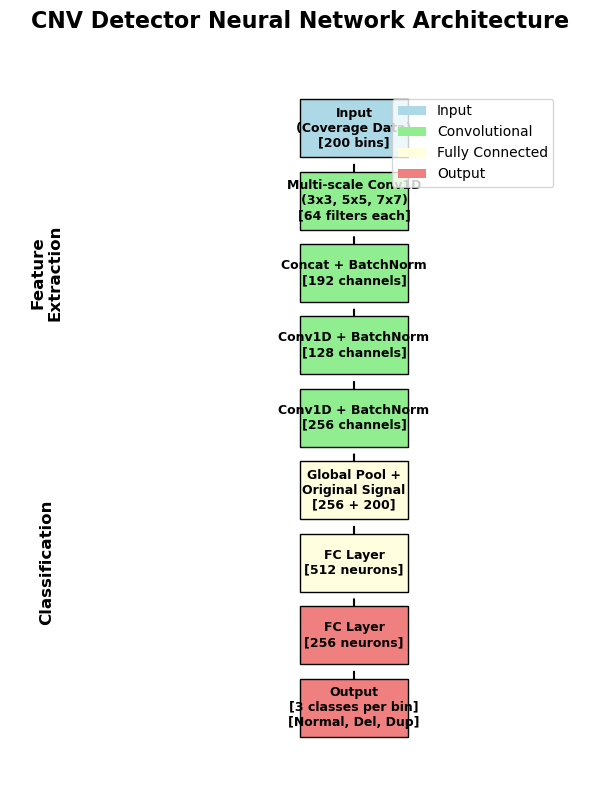


4. Training the model...
Starting training...
Epoch   0: Train Loss: 1.1350, Train Acc: 60.16%, Val Loss: 0.6938, Val Acc: 80.95%
Epoch  10: Train Loss: 0.4850, Train Acc: 82.04%, Val Loss: 0.4667, Val Acc: 82.43%
Epoch  20: Train Loss: 0.4073, Train Acc: 85.59%, Val Loss: 0.3924, Val Acc: 86.36%
Training completed!

5. Visualizing training results...


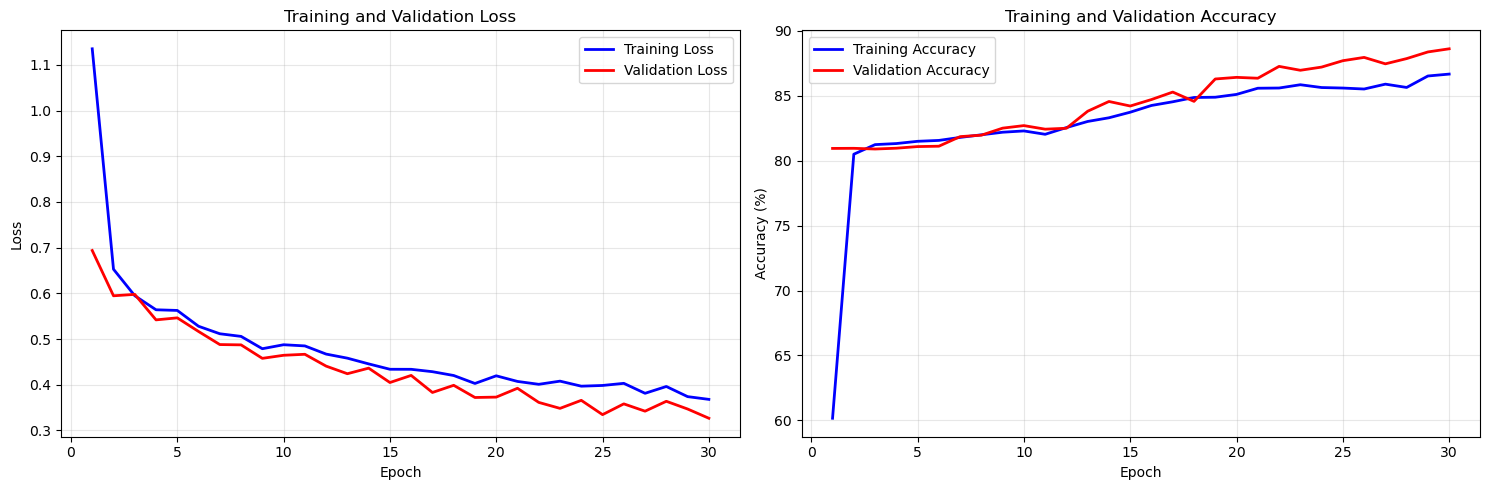


6. Evaluating on test set...
Test Loss: 0.2953
Test Accuracy: 89.50%

Detailed Classification Report:
              precision    recall  f1-score   support

      Normal       0.91      0.98      0.94     19902
    Deletion       0.78      0.47      0.59      2151
 Duplication       0.80      0.54      0.64      1947

    accuracy                           0.89     24000
   macro avg       0.83      0.66      0.72     24000
weighted avg       0.89      0.89      0.88     24000


7. Visualizing CNV detection results...


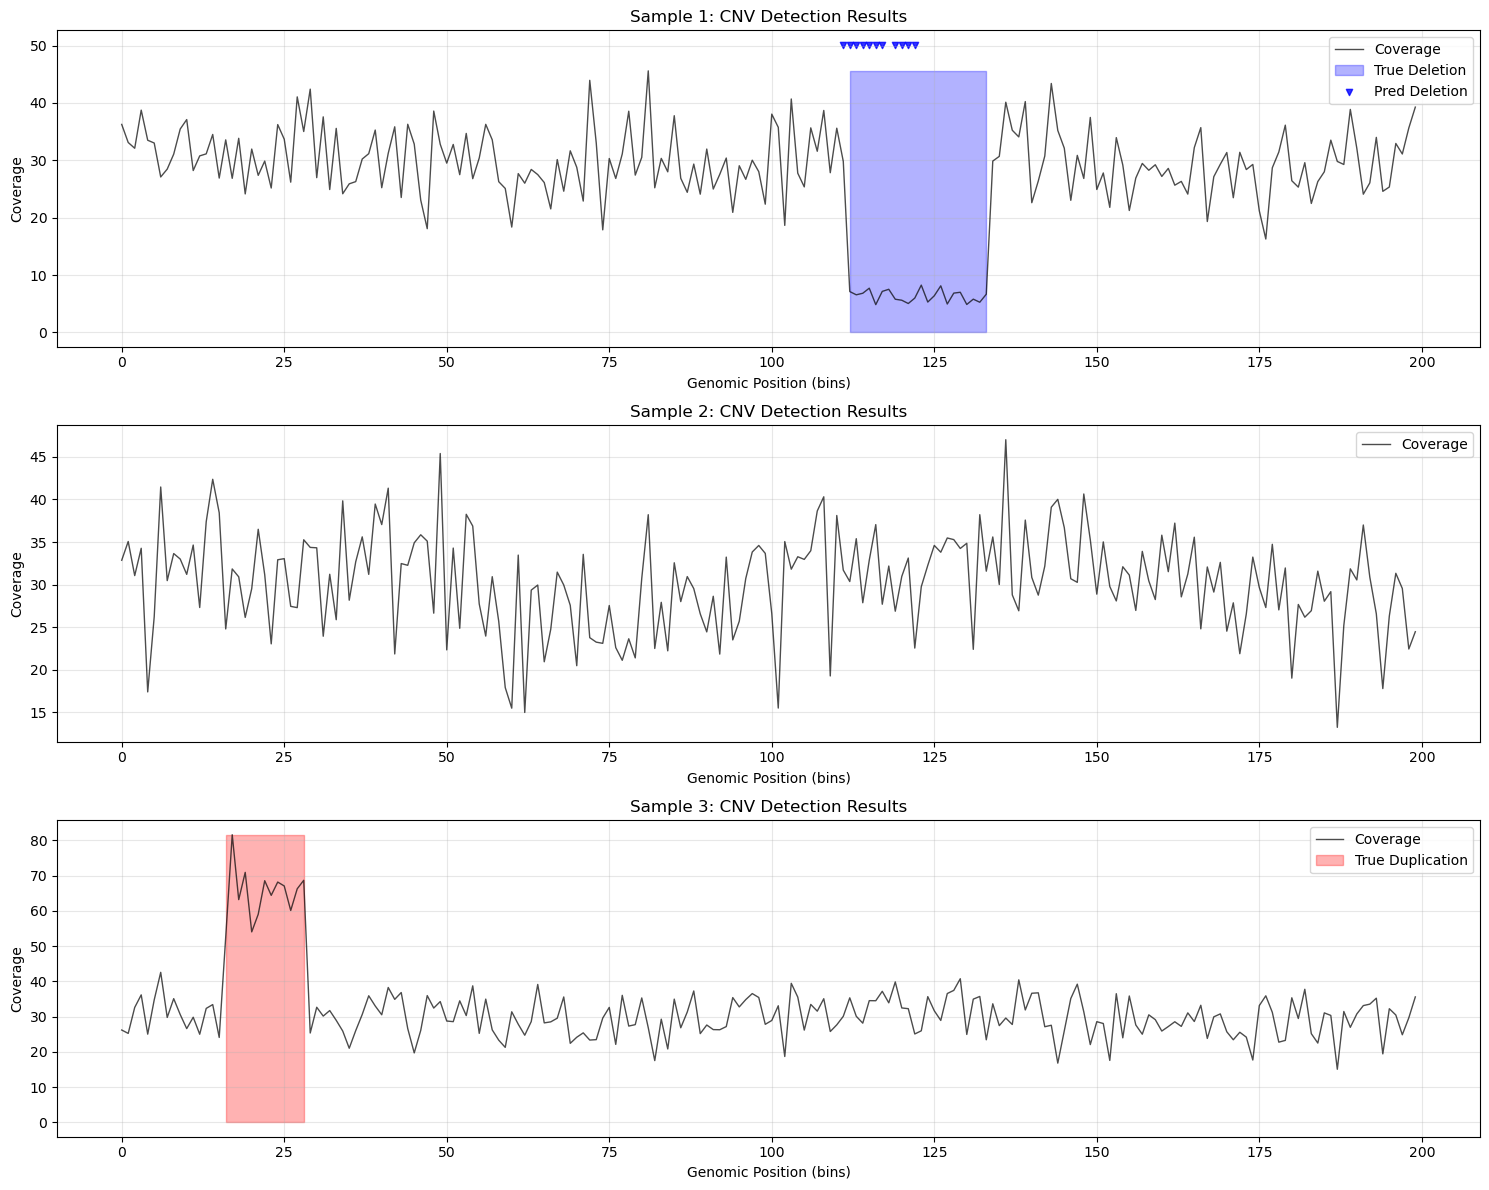


=== Analysis Complete ===


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

class CNVDataGenerator:
    """
    Generate simulated copy number variation data for training.
    
    Simulates genomic bins with coverage data and introduces CNVs
    (deletions and duplications) at various locations.
    """
    
    def __init__(self, n_samples=1000, sequence_length=200, bin_size=1000):
        self.n_samples = n_samples
        self.sequence_length = sequence_length  # Number of genomic bins
        self.bin_size = bin_size  # Size of each bin in bp
        
    def generate_normal_coverage(self, mean_coverage=30, noise_std=5):
        """Generate baseline coverage with realistic noise patterns."""
        # Base coverage with some regional variation
        base_coverage = np.random.normal(mean_coverage, noise_std/2, self.sequence_length)
        
        # Add GC content bias (some regions have higher/lower coverage)
        gc_bias = np.sin(np.linspace(0, 4*np.pi, self.sequence_length)) * 3
        base_coverage += gc_bias
        
        # Add random noise
        noise = np.random.normal(0, noise_std, self.sequence_length)
        coverage = base_coverage + noise
        
        # Ensure non-negative coverage
        coverage = np.maximum(coverage, 1)
        
        return coverage
    
    def introduce_cnv(self, coverage, cnv_type, start_pos, end_pos, intensity=0.5):
        """
        Introduce a copy number variation into the coverage data.
        
        Args:
            coverage: Base coverage array
            cnv_type: 'deletion' or 'duplication'
            start_pos: Start position of CNV
            end_pos: End position of CNV
            intensity: Strength of the CNV (0.0 to 1.0)
        """
        cnv_coverage = coverage.copy()
        
        if cnv_type == 'deletion':
            # Reduce coverage in the CNV region
            reduction_factor = 0.1 + (1 - intensity) * 0.4  # 0.1 to 0.5
            cnv_coverage[start_pos:end_pos] *= reduction_factor
            
        elif cnv_type == 'duplication':
            # Increase coverage in the CNV region
            amplification_factor = 1.5 + intensity * 1.0  # 1.5 to 2.5
            cnv_coverage[start_pos:end_pos] *= amplification_factor
            
        return cnv_coverage
    
    def generate_dataset(self):
        """Generate complete dataset with CNVs and labels."""
        X = []  # Coverage data
        y = []  # Labels (0=normal, 1=deletion, 2=duplication)
        cnv_positions = []  # For visualization
        
        for i in range(self.n_samples):
            # Generate base coverage
            coverage = self.generate_normal_coverage()
            
            # Create label array (initially all normal)
            labels = np.zeros(self.sequence_length, dtype=int)
            
            # Randomly decide if this sample has CNVs
            has_cnv = np.random.random() > 0.3  # 70% chance of having CNV
            
            sample_cnvs = []
            
            if has_cnv:
                # Add 1-3 CNVs to this sample
                n_cnvs = np.random.randint(1, 4)
                
                for _ in range(n_cnvs):
                    # Random CNV parameters
                    cnv_length = np.random.randint(10, 50)  # CNV length in bins
                    start_pos = np.random.randint(0, self.sequence_length - cnv_length)
                    end_pos = start_pos + cnv_length
                    
                    cnv_type = np.random.choice(['deletion', 'duplication'])
                    intensity = np.random.uniform(0.3, 0.8)
                    
                    # Apply CNV to coverage
                    coverage = self.introduce_cnv(coverage, cnv_type, start_pos, end_pos, intensity)
                    
                    # Update labels
                    if cnv_type == 'deletion':
                        labels[start_pos:end_pos] = 1
                    else:  # duplication
                        labels[start_pos:end_pos] = 2
                    
                    sample_cnvs.append({
                        'type': cnv_type,
                        'start': start_pos,
                        'end': end_pos,
                        'intensity': intensity
                    })
            
            X.append(coverage)
            y.append(labels)
            cnv_positions.append(sample_cnvs)
        
        return np.array(X), np.array(y), cnv_positions

class CNVDataset(Dataset):
    """PyTorch Dataset for CNV detection."""
    
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class CNVDetectorCNN(nn.Module):
    """
    Convolutional Neural Network for Copy Number Variation detection.
    
    Architecture:
    - 1D Convolutions to capture local patterns in coverage
    - Batch normalization and dropout for regularization
    - Multi-scale feature extraction with different kernel sizes
    - Classification head for 3-class prediction (normal, deletion, duplication)
    """
    
    def __init__(self, sequence_length=200, n_classes=3):
        super(CNVDetectorCNN, self).__init__()
        
        self.sequence_length = sequence_length
        self.n_classes = n_classes
        
        # Multi-scale convolutional layers
        # Small kernels for local patterns
        self.conv1a = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.conv1b = nn.Conv1d(1, 64, kernel_size=5, padding=2)
        self.conv1c = nn.Conv1d(1, 64, kernel_size=7, padding=3)
        
        # Combine multi-scale features
        self.conv2 = nn.Conv1d(192, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        
        # Batch normalization layers
        self.bn1 = nn.BatchNorm1d(192)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(256)
        
        # Dropout for regularization
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.4)
        
        # Global features
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        
        # Classification layers
        self.fc1 = nn.Linear(256 + sequence_length, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, n_classes * sequence_length)
        
        self.dropout_fc = nn.Dropout(0.5)
        
    def forward(self, x):
        batch_size = x.size(0)
        
        # Input shape: (batch_size, sequence_length)
        # Reshape for 1D convolution: (batch_size, 1, sequence_length)
        x_conv = x.unsqueeze(1)
        
        # Multi-scale convolutions
        conv1a_out = F.relu(self.conv1a(x_conv))
        conv1b_out = F.relu(self.conv1b(x_conv))
        conv1c_out = F.relu(self.conv1c(x_conv))
        
        # Concatenate multi-scale features
        x_conv = torch.cat([conv1a_out, conv1b_out, conv1c_out], dim=1)
        x_conv = self.bn1(x_conv)
        x_conv = self.dropout1(x_conv)
        
        # Additional convolutional layers
        x_conv = F.relu(self.conv2(x_conv))
        x_conv = self.bn2(x_conv)
        x_conv = self.dropout2(x_conv)
        
        x_conv = F.relu(self.conv3(x_conv))
        x_conv = self.bn3(x_conv)
        x_conv = self.dropout3(x_conv)
        
        # Global pooling for global features
        global_features = self.global_pool(x_conv).squeeze(-1)
        
        # Combine original signal with global features
        combined = torch.cat([global_features, x], dim=1)
        
        # Fully connected layers
        x_fc = F.relu(self.fc1(combined))
        x_fc = self.dropout_fc(x_fc)
        x_fc = F.relu(self.fc2(x_fc))
        x_fc = self.dropout_fc(x_fc)
        
        # Output layer
        output = self.fc3(x_fc)
        
        # Reshape to (batch_size, sequence_length, n_classes)
        output = output.view(batch_size, self.sequence_length, self.n_classes)
        
        return output

class CNVTrainer:
    """Training and evaluation pipeline for CNV detection."""
    
    def __init__(self, model, device='cpu'):
        self.model = model.to(device)
        self.device = device
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        
    def train_epoch(self, train_loader, optimizer, criterion):
        """Train for one epoch."""
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(self.device), batch_y.to(self.device)
            
            optimizer.zero_grad()
            
            # Forward pass
            outputs = self.model(batch_x)
            
            # Reshape for loss calculation
            outputs = outputs.view(-1, 3)  # (batch_size * seq_length, n_classes)
            batch_y = batch_y.view(-1)     # (batch_size * seq_length)
            
            loss = criterion(outputs, batch_y)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            # Calculate accuracy
            _, predicted = outputs.max(1)
            total += batch_y.size(0)
            correct += predicted.eq(batch_y).sum().item()
        
        avg_loss = total_loss / len(train_loader)
        accuracy = 100. * correct / total
        
        return avg_loss, accuracy
    
    def validate(self, val_loader, criterion):
        """Validate the model."""
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(self.device), batch_y.to(self.device)
                
                outputs = self.model(batch_x)
                
                # Reshape for loss calculation
                outputs = outputs.view(-1, 3)
                batch_y = batch_y.view(-1)
                
                loss = criterion(outputs, batch_y)
                total_loss += loss.item()
                
                # Calculate accuracy
                _, predicted = outputs.max(1)
                total += batch_y.size(0)
                correct += predicted.eq(batch_y).sum().item()
        
        avg_loss = total_loss / len(val_loader)
        accuracy = 100. * correct / total
        
        return avg_loss, accuracy
    
    def train(self, train_loader, val_loader, epochs=50, lr=0.001):
        """Complete training loop."""
        optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=1e-4)
        criterion = nn.CrossEntropyLoss()
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
        
        print("Starting training...")
        
        for epoch in range(epochs):
            # Training
            train_loss, train_acc = self.train_epoch(train_loader, optimizer, criterion)
            
            # Validation
            val_loss, val_acc = self.validate(val_loader, criterion)
            
            # Learning rate scheduling
            scheduler.step(val_loss)
            
            # Store metrics
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_accuracies.append(train_acc)
            self.val_accuracies.append(val_acc)
            
            if epoch % 10 == 0:
                print(f'Epoch {epoch:3d}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
                      f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        
        print("Training completed!")

def visualize_network_architecture(model):
    """Visualize the neural network architecture."""
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    # Network structure visualization
    layers = [
        "Input\n(Coverage Data)\n[200 bins]",
        "Multi-scale Conv1D\n(3x3, 5x5, 7x7)\n[64 filters each]",
        "Concat + BatchNorm\n[192 channels]",
        "Conv1D + BatchNorm\n[128 channels]", 
        "Conv1D + BatchNorm\n[256 channels]",
        "Global Pool +\nOriginal Signal\n[256 + 200]",
        "FC Layer\n[512 neurons]",
        "FC Layer\n[256 neurons]",
        "Output\n[3 classes per bin]\n[Normal, Del, Dup]"
    ]
    
    # Draw network layers
    y_positions = np.linspace(0.9, 0.1, len(layers))
    
    for i, (layer, y_pos) in enumerate(zip(layers, y_positions)):
        # Layer box
        box_width = 0.15
        box_height = 0.08
        
        if i == 0:  # Input layer
            color = 'lightblue'
        elif i < 5:  # Convolutional layers
            color = 'lightgreen'
        elif i < 7:  # Fully connected layers
            color = 'lightyellow'
        else:  # Output layer
            color = 'lightcoral'
            
        rect = plt.Rectangle((0.4, y_pos - box_height/2), box_width, box_height,
                           facecolor=color, edgecolor='black', linewidth=1)
        ax.add_patch(rect)
        
        # Layer text
        ax.text(0.475, y_pos, layer, ha='center', va='center', fontsize=9, weight='bold')
        
        # Arrows between layers
        if i < len(layers) - 1:
            ax.arrow(0.475, y_pos - box_height/2 - 0.01, 0, -0.04, 
                    head_width=0.01, head_length=0.01, fc='black', ec='black')
    
    # Add side annotations
    ax.text(0.05, 0.7, "Feature\nExtraction", ha='center', va='center', 
            fontsize=12, weight='bold', rotation=90)
    ax.text(0.05, 0.3, "Classification", ha='center', va='center', 
            fontsize=12, weight='bold', rotation=90)
    
    ax.set_xlim(0, 0.8)
    ax.set_ylim(0, 1)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title('CNV Detector Neural Network Architecture', fontsize=16, weight='bold', pad=20)
    
    # Add legend
    legend_elements = [
        plt.Rectangle((0, 0), 1, 1, facecolor='lightblue', label='Input'),
        plt.Rectangle((0, 0), 1, 1, facecolor='lightgreen', label='Convolutional'),
        plt.Rectangle((0, 0), 1, 1, facecolor='lightyellow', label='Fully Connected'),
        plt.Rectangle((0, 0), 1, 1, facecolor='lightcoral', label='Output')
    ]
    ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.95, 0.95))
    
    plt.tight_layout()
    plt.show()

def visualize_training_results(trainer):
    """Visualize training progress."""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    epochs = range(1, len(trainer.train_losses) + 1)
    
    # Loss curves
    axes[0].plot(epochs, trainer.train_losses, 'b-', label='Training Loss', linewidth=2)
    axes[0].plot(epochs, trainer.val_losses, 'r-', label='Validation Loss', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy curves
    axes[1].plot(epochs, trainer.train_accuracies, 'b-', label='Training Accuracy', linewidth=2)
    axes[1].plot(epochs, trainer.val_accuracies, 'r-', label='Validation Accuracy', linewidth=2)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def visualize_cnv_predictions(model, test_data, test_labels, cnv_positions, n_samples=3):
    """Visualize CNV predictions on test samples."""
    model.eval()
    
    fig, axes = plt.subplots(n_samples, 1, figsize=(15, 4*n_samples))
    if n_samples == 1:
        axes = [axes]
    
    class_names = ['Normal', 'Deletion', 'Duplication']
    colors = ['gray', 'blue', 'red']
    
    with torch.no_grad():
        for i in range(n_samples):
            # Get prediction
            sample_input = torch.FloatTensor(test_data[i:i+1])
            output = model(sample_input)
            predictions = torch.argmax(output, dim=2).squeeze().numpy()
            
            # Plot coverage data
            positions = np.arange(len(test_data[i]))
            axes[i].plot(positions, test_data[i], 'k-', alpha=0.7, linewidth=1, label='Coverage')
            
            # Plot true CNVs
            true_labels = test_labels[i]
            for class_idx in [1, 2]:  # Deletion and duplication
                mask = true_labels == class_idx
                if np.any(mask):
                    axes[i].fill_between(positions, 0, np.max(test_data[i]), 
                                       where=mask, alpha=0.3, color=colors[class_idx], 
                                       label=f'True {class_names[class_idx]}')
            
            # Plot predicted CNVs
            for class_idx in [1, 2]:  # Deletion and duplication
                mask = predictions == class_idx
                if np.any(mask):
                    # Plot as markers above the coverage
                    pred_positions = positions[mask]
                    pred_heights = np.max(test_data[i]) * 1.1
                    axes[i].scatter(pred_positions, [pred_heights] * len(pred_positions),
                                  marker='v' if class_idx == 1 else '^', 
                                  color=colors[class_idx], s=20, alpha=0.8,
                                  label=f'Pred {class_names[class_idx]}')
            
            axes[i].set_xlabel('Genomic Position (bins)')
            axes[i].set_ylabel('Coverage')
            axes[i].set_title(f'Sample {i+1}: CNV Detection Results')
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def main():
    """Main execution function."""
    print("=== CNV Detection with PyTorch ===\n")
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}\n")
    
    # Generate synthetic CNV data
    print("1. Generating synthetic CNV data...")
    data_generator = CNVDataGenerator(n_samples=800, sequence_length=200)
    X, y, cnv_positions = data_generator.generate_dataset()
    
    print(f"Generated {X.shape[0]} samples with {X.shape[1]} genomic bins each")
    print(f"Class distribution:")
    unique, counts = np.unique(y, return_counts=True)
    for class_idx, count in zip(unique, counts):
        class_names = ['Normal', 'Deletion', 'Duplication']
        print(f"  {class_names[class_idx]}: {count:,} bins ({count/np.prod(y.shape)*100:.1f}%)")
    
    # Split data
    train_size = int(0.7 * len(X))
    val_size = int(0.15 * len(X))
    
    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
    X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]
    cnv_test = cnv_positions[train_size+val_size:]
    
    # Create datasets and dataloaders
    train_dataset = CNVDataset(X_train, y_train)
    val_dataset = CNVDataset(X_val, y_val)
    test_dataset = CNVDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    print(f"\nDataset splits:")
    print(f"  Training: {len(train_dataset)} samples")
    print(f"  Validation: {len(val_dataset)} samples") 
    print(f"  Test: {len(test_dataset)} samples")
    
    # Create and visualize model
    print("\n2. Creating neural network model...")
    model = CNVDetectorCNN(sequence_length=200, n_classes=3)
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model created with {total_params:,} total parameters ({trainable_params:,} trainable)")
    
    # Visualize network architecture
    print("\n3. Visualizing network architecture...")
    visualize_network_architecture(model)
    
    # Train model
    print("\n4. Training the model...")
    trainer = CNVTrainer(model, device)
    trainer.train(train_loader, val_loader, epochs=30, lr=0.001)
    
    # Visualize training results
    print("\n5. Visualizing training results...")
    visualize_training_results(trainer)
    
    # Evaluate on test set
    print("\n6. Evaluating on test set...")
    test_loss, test_accuracy = trainer.validate(test_loader, nn.CrossEntropyLoss())
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    
    # Generate detailed classification report
    model.eval()
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.to(device)
            outputs = model(batch_x)
            predictions = torch.argmax(outputs, dim=2)
            
            all_predictions.extend(predictions.cpu().numpy().flatten())
            all_targets.extend(batch_y.numpy().flatten())
    
    # Classification report
    class_names = ['Normal', 'Deletion', 'Duplication']
    print("\nDetailed Classification Report:")
    print(classification_report(all_targets, all_predictions, target_names=class_names))
    
    # Visualize predictions
    print("\n7. Visualizing CNV detection results...")
    visualize_cnv_predictions(model, X_test, y_test, cnv_test, n_samples=3)
    
    print("\n=== Analysis Complete ===")
    
    return model, trainer, (X_test, y_test, cnv_test)

if __name__ == "__main__":
    model, trainer, test_data = main()